In [12]:
### Imports ###
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.style.use('seaborn-poster')
from matplotlib.pyplot import *
from datetime import timedelta
import calendar # for getting month name i.e. Feb from month number
from urllib.request import urlretrieve # for getting data from URLs
from datetime import datetime
import datetime as dt
import os # for deleting files
import statsmodels
import statsmodels.api as sm # for time series decomposition
from statsmodels.tsa.filters.hp_filter import hpfilter # for Hodrick-Prescott filter
%matplotlib inline

### Get data ###
def get_data(location_input):
    '''Returns data for desired location.
    
    Keyword arguments:
    location -- string of location wanted.
    '''
    # Dictionary of URLs from different locations
    Derby = {
        '2020' : 'https://uk-air.defra.gov.uk/data_files/site_data/DESA_2020.csv',
        '2019' : 'https://uk-air.defra.gov.uk/data_files/site_data/DESA_2019.csv',
        '2018' : 'https://uk-air.defra.gov.uk/data_files/site_data/DESA_2018.csv',
        '2017' : 'https://uk-air.defra.gov.uk/data_files/site_data/DESA_2017.csv'
    }
    Reading = {
        '2020' : 'https://uk-air.defra.gov.uk/data_files/site_data/REA5_2020.csv',
        '2019' : 'https://uk-air.defra.gov.uk/data_files/site_data/REA5_2019.csv',
        '2018' : 'https://uk-air.defra.gov.uk/data_files/site_data/REA5_2018.csv',
        '2017' : 'https://uk-air.defra.gov.uk/data_files/site_data/REA5_2017.csv'
    }
    Nottingham_Centre = {
        '2020' : 'https://uk-air.defra.gov.uk/data_files/site_data/NOTT_2020.csv',
        '2019' : 'https://uk-air.defra.gov.uk/data_files/site_data/NOTT_2019.csv',
        '2018' : 'https://uk-air.defra.gov.uk/data_files/site_data/NOTT_2018.csv',
        '2017' : 'https://uk-air.defra.gov.uk/data_files/site_data/NOTT_2017.csv'
    }
    Burton_On_Trent_Centre = {
        '2020' : 'https://uk-air.defra.gov.uk/data_files/site_data/BOTR_2020.csv',
        '2019' : 'https://uk-air.defra.gov.uk/data_files/site_data/BOTR_2019.csv',
        '2018' : 'https://uk-air.defra.gov.uk/data_files/site_data/BOTR_2018.csv'  
    } # no 2017 data for Burton
    
    # Turning above dictionaries into one dictionary
    data_locations = {
      "Derby" : Derby,
      "Reading" : Reading,
      "Nottingham_Centre" : Nottingham_Centre,
      "Burton_Centre" : Burton_On_Trent_Centre
    }

    global df_2020, df_2019, df_2018, df_2017,location_string # so that these can be used outside of function
    location_string = location_input # for plot titles
    
    # Getting URLs for requested location
    URL_2020 = data_locations[location_input]['2020']
    URL_2019 = data_locations[location_input]['2019']
    URL_2018 = data_locations[location_input]['2018']
    URL_2017 = data_locations[location_input]['2017']
   
    # Making dataframes
    df_2020 = pd.read_csv(URL_2020,skiprows=4)
    df_2019 = pd.read_csv(URL_2019,skiprows=4)
    df_2018 = pd.read_csv(URL_2018,skiprows=4)
    df_2017 = pd.read_csv(URL_2017,skiprows=4)
    
    print('Successfully got data for {}!'.format(location_input))
    
get_data('Derby')

### Cleaning data ###
def datetime_cleaner(variable):
    '''Take every date + time where date is i.e. 1/1/2020 24:00 and turn it into 2/1/2020 00:00. 
    Also removes redundant columns
    
    Keyword arguments:
    variable -- the dataframe inputted i.e. df_2020
    '''
    # Changing date from object to datetime
    variable['Date'] = pd.to_datetime(variable['Date']).dt.strftime('%d-%m-%Y') # makes sure string is in correct format
    variable['Date'] = pd.to_datetime(variable['Date']) # converts to datetime
    
    # Loop to add 1 for every 24th entry, as they are stored as date x & 24:00 when they need to be date x + 1 & 00:00
    counter = 0
    for i, row in variable.iterrows():
        counter += 1
        if counter % 24 == 0:
            value = variable.at[i,'Date'] + pd.Timedelta(1,unit='d')
            variable.at[i,'Date'] = value
    
    # Replacing 24:00 with 00:00
    variable['time'] = variable['time'].replace(to_replace='24:00',value='00:00') 
    
    # Combining date and time columns
    variable['Date String'] = variable['Date'].astype(str)
    variable['Date Time String'] = variable['Date String'] + " " + variable['time']
    variable['Date Time'] = pd.to_datetime(variable['Date Time String'])
    
    # Feature Engineering
    variable['Week'] = variable['Date Time'].dt.week
    variable['Day Of Week'] = variable['Date Time'].dt.dayofweek
    variable['Quarter'] = variable['Date Time'].dt.quarter
    variable['Month'] = variable['Date Time'].dt.month
    variable['Weekday Or Weekend'] = np.where(variable['Day Of Week'] >=5,'Weekend','Weekday')
    variable['Total'] = variable['Nitric oxide'] + variable['Nitrogen dioxide']
    
    # Setting index to be Date Time
    variable.index = variable['Date Time']
    
    # Removing columns
    variable.drop(['Date','time','Date String','Date Time String'],axis=1,inplace=True)
    variable.drop(['status','unit','status.1','unit.1','status.2','unit.2'],axis=1,inplace=True)
          
    # Removing columns that only exists in some locations (i.e. Reading has 'unit.3') whereas Derby doesn't
    variable.drop(['status.3','unit.3'],axis=1,inplace=True,errors='ignore') 
    
datetime_cleaner(df_2020)
datetime_cleaner(df_2019)
datetime_cleaner(df_2018)
datetime_cleaner(df_2017)

# Make new dataframe containing all data
frames = [df_2017,df_2018,df_2019,df_2020]
df_all = pd.concat(frames)
df_all.index = df_all['Date Time']

# removing null values (data doesn't start until 2017-01-20 11:00:00)
df_all_nonull = df_all.dropna()

Successfully got data for Derby!


In [20]:
df_all_nonull_day = df_all_nonull.resample('D').sum()
df_all_nonull_week = df_all_nonull.resample('W').sum()

# Statsmodels library 
- For statistical testing of time series data!

## Notes
### Hodrick-Prescott filter
- Attempts to serarate a time series into a trend component and a cyclical component
- Default lambda of 1600 recommended, use 6.25 for annual data and 129,600 for monthly data
- I've googled it and Hodrick-Prescott is not built to work with hourly data

### ETS (Error-Trend-Seasonality) Models
Includes:
- Exponential smoothing
- Trend methods models
- ETS Decomposition

Two main types of ETS model:
- Additive: used when trend seems more linear and seasonality & trend components seem to be constant over time
- Multiplicative: when increasing/ decreasing at a non-linear rate i.e. exponential growth

#### ETS Decomposition
- Plots the normal data ("observed"), the trend, the isolated seasonal component, and residual (noise)


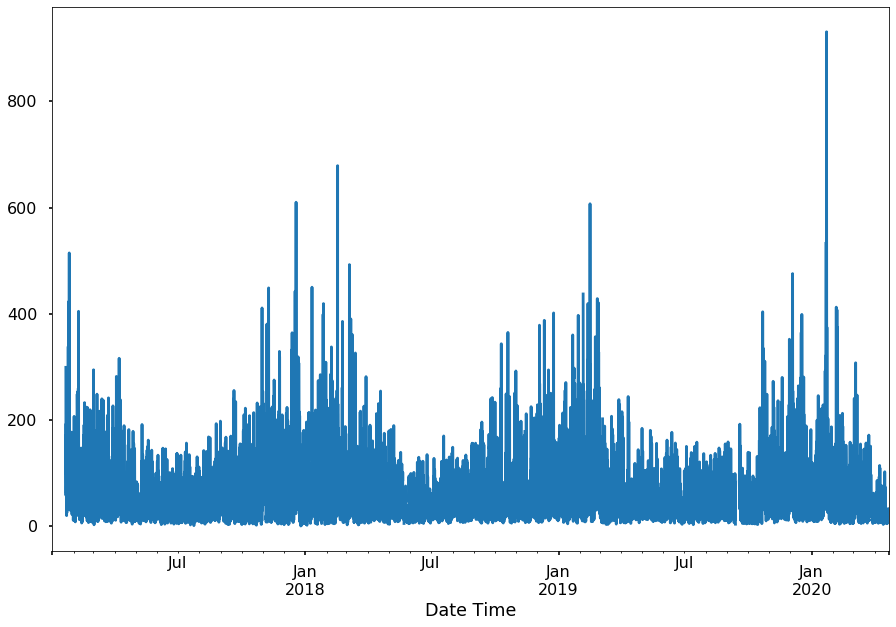

In [14]:
df_all['Total'].plot(figsize=[15,10])

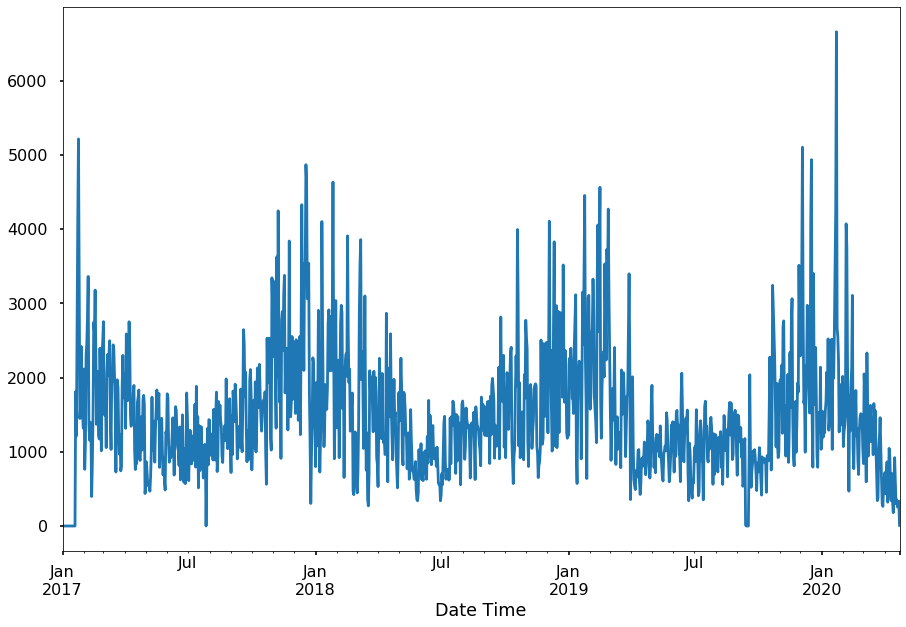

In [18]:
df_all['Total'].resample('D').sum().plot(figsize=[15,10])

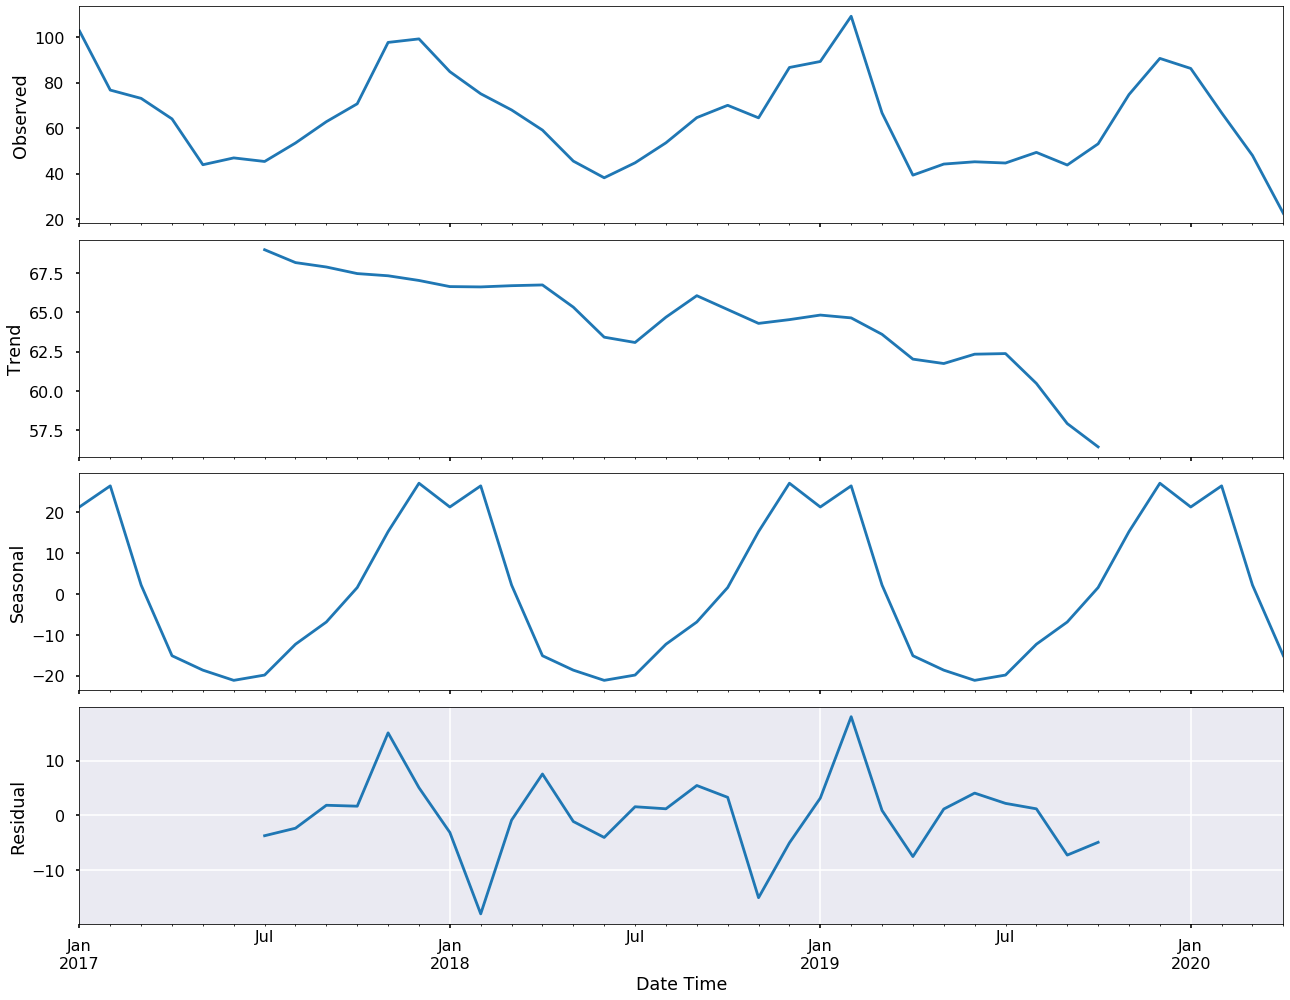

In [10]:
from pylab import rcParams
rcParams['figure.figsize'] = 18, 14
y = df_all['Total'].resample('M').mean()
decomposition = sm.tsa.seasonal_decompose(y, model='additive')
fig = decomposition.plot()

# Stylings
ax = fig.gca() # not entirely sure what this does but it lets me make an ax after the fact for editing!
ax.set_facecolor('#eaeaf2')
plt.grid(True,color='w')

# General Forecasting Models
- Machine Learning with Time Series data

## Descriptive statistics and tests to use on our data (from Udemy course video "Descriptive Statistics and Tests - Part Two)
### Augmented Dickey Fuller

In [24]:
# ignore harmless warnings
import warnings
warnings.filterwarnings('ignore')

# Augmented Dickey-Fuller test to test if data is stationary or not
from statsmodels.tsa.stattools import adfuller

# Description of what's going on below:
## You can do adfuller(df_all_nonull['Total']), but it gives you a weird tuple of values
## Doing help(adfuller) or adfuller? returns the documentation, and explains what the values in the tuple mean
## The below function (which is way beyond my Pythonic skill to come up with on my own) prints the values with their description
dftest = adfuller(df_all_nonull_day['Total'])
dfout = pd.Series(dftest[0:4],index=['ADF Test Statistic','p-value','# Lags Used','# Observations'])

for key,val in dftest[4].items():
    dfout[f'critical values ({key})'] = val
    
dfout

ADF Test Statistic         -3.032933
p-value                     0.031931
# Lags Used                20.000000
# Observations           1168.000000
critical values (1%)       -3.435961
critical values (5%)       -2.864018
critical values (10%)      -2.568089
dtype: float64

- Most important thing here is the p-value. Should you reject null or not
- **If P value is smaller than 0.05, reject null hypothesis, data is stationary**
- Didn't expect that, as seasonality is clear! But I guess there's no trend?

## Granger Causality test
- Granger causality is a way to investigate causality between two variables in a time series. 
- This would be great if I could get weather data, but for now I'll do nitric oxide vs nitrogen dioxide
- However intuitively I know one of these doesn't *cause* the other

In [11]:
from statsmodels.tsa.stattools import grangercausalitytests as gct

In [25]:
gct(df_all_nonull_day[['Nitric oxide','Nitrogen dioxide']],maxlag=4); # using a ; can stop statsmodels from duplicating output


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=11.3291 , p=0.0008  , df_denom=1185, df_num=1
ssr based chi2 test:   chi2=11.3577 , p=0.0008  , df=1
likelihood ratio test: chi2=11.3038 , p=0.0008  , df=1
parameter F test:         F=11.3291 , p=0.0008  , df_denom=1185, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=5.2296  , p=0.0055  , df_denom=1182, df_num=2
ssr based chi2 test:   chi2=10.5034 , p=0.0052  , df=2
likelihood ratio test: chi2=10.4572 , p=0.0054  , df=2
parameter F test:         F=5.2296  , p=0.0055  , df_denom=1182, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=2.8904  , p=0.0344  , df_denom=1179, df_num=3
ssr based chi2 test:   chi2=8.7228  , p=0.0332  , df=3
likelihood ratio test: chi2=8.6909  , p=0.0337  , df=3
parameter F test:         F=2.8904  , p=0.0344  , df_denom=1179, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=3.4130  , p=0.

- Extremely low P values: causality! 

In [26]:
from statsmodels.graphics.tsaplots import month_plot, quarter_plot

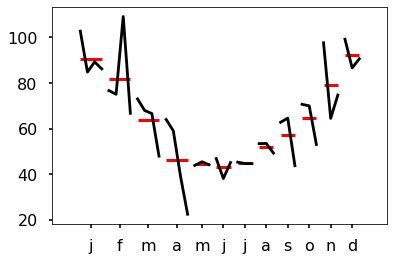

In [27]:
month_plot(df_all['Total'].resample('M').mean()); # had to resample to monthly to make it work 

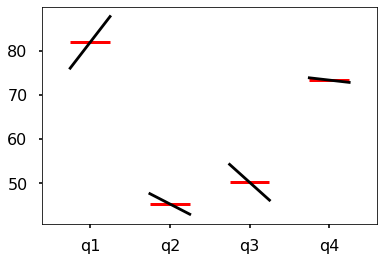

In [29]:
quarter_plot(df_all.loc['2018-01-01':'2019-12-31']['Total'].resample('Q').mean()); # had to resample to monthly to make it work 

# ARIMA
- using the pmdarima library to perform a GridSearch of ARIMA models to find the best p,d,q
- will need to pip install pmdarima

# NOTE TO SELF - maybe I should be doing ARIMA on daily or weekly data - maybe hourly is too hard and that's why the AIC value is so high

In [ ]:
from pmdarima import auto_arima
import warnings
warnings.filterwarnings('ignore') # prevents any statsmodels based warnings popping up 

In [ ]:
help(auto_arima) # just to demonstrate how many bloody parameters there are 

In [ ]:
# dataframe of 2017 (data started on the 21st of Jan) to end of 2019, so I can predict 2020 
training= df_all_nonull_day.loc['2017-01-22':'2019-12-31']
training.dropna(inplace=True)

In [ ]:
stepwise_fit = auto_arima(training['Nitric oxide'],start_p=0,start_q=0,max_p=6,max_q=3,seasonal=False,trace=True) 

In [ ]:
stepwise_fit.summary()

In [ ]:
dftest = adfuller(training['Total'])
dfout = pd.Series(dftest[0:4],index=['ADF Test Statistic','p-value','# Lags Used','# Observations'])

for key,val in dftest[4].items():
    dfout[f'critical values ({key})'] = val
    
dfout

In [ ]:
stepwise_fit = auto_arima(training['Nitric oxide'],start_p=0,start_q=0,max_p=4,max_q=4,seasonal=False,trace=True) 